# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [ ]:
!pip install PyArabic
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.5 MB/s eta 0:00:00


In [182]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
import nltk
from nltk.stem.isri import ISRIStemmer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Download the Dataset

In [93]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
spam-messages.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spam-messages.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [117]:
f = '/content/spam.csv'
df = pd.read_csv(f, sep='\t')

In [118]:
df

,"text,label"
0,"Go until jurong point, crazy.. Available only ..."
1,"Ok lar... Joking wif u oni...,ham"
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
...,...
5567,This is the 2nd time we have tried 2 contact u...
5568,"Will Ì_ b going to esplanade fr home?,ham"
5569,"Pity, * was in mood for that. So...any other s..."
5570,The guy did some bitching but I acted like i'd...


In [119]:
# df[['text', 'label']] = df['text,label'].str.split(',', n=1, expand=True)
# df.drop(columns=['text,label'], inplace=True)


In [120]:
df[['text', 'label']] = df['text,label'].str.rsplit(',', n=1, expand=True)
df.drop(columns=['text,label'], inplace=True)

In [121]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [122]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [123]:
label_counts = df['label'].value_counts()
print(label_counts)


label
ham     4825
spam     747
Name: count, dtype: int64


In [125]:
label_proportions = df['label'].value_counts(normalize=True)
print(label_proportions)

label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


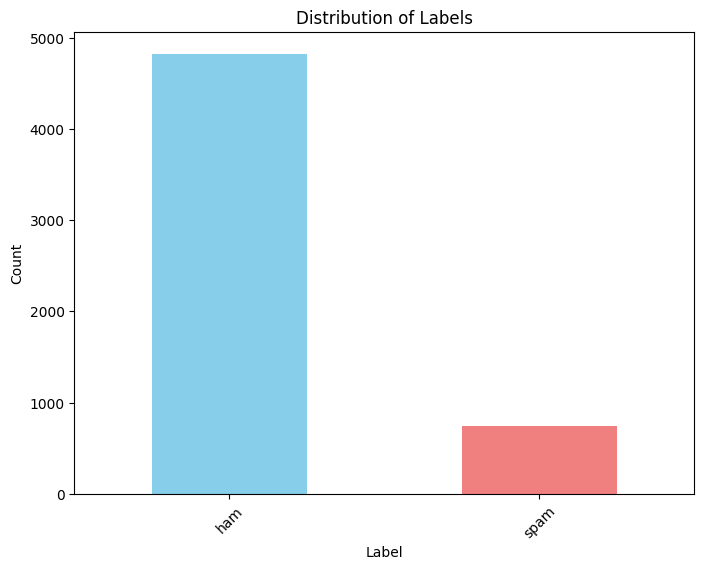

In [128]:
df_filtered = df[df['label'].isin(['ham', 'spam'])]
plt.figure(figsize=(8, 6))
df_filtered['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [129]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [130]:
df.columns

Index(['text', 'label'], dtype='object')

In [131]:
df.head(50)

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
5,FreeMsg Hey there darling it's been 3 week's n...,spam
6,Even my brother is not like to speak with me. ...,ham
7,As per your request 'Melle Melle (Oru Minnamin...,ham
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam


In [132]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [133]:
df.columns

Index(['text', 'label'], dtype='object')

In [134]:
df.describe()

,text,label
count,5572,5572
unique,5389,2
top,"Sorry, I'll call later",ham
freq,16,4825


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<Axes: xlabel='label'>

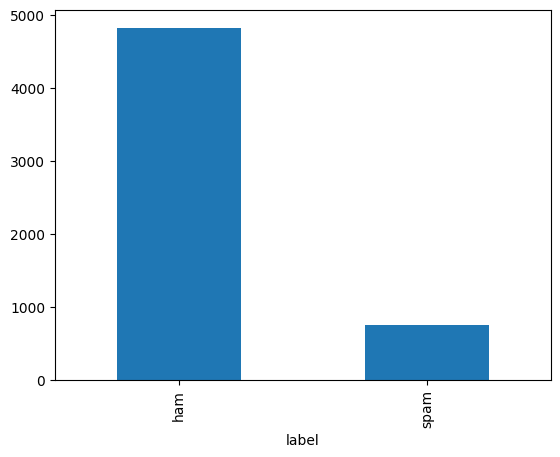

In [136]:
df['label'].value_counts().plot(kind='bar')

<Axes: >

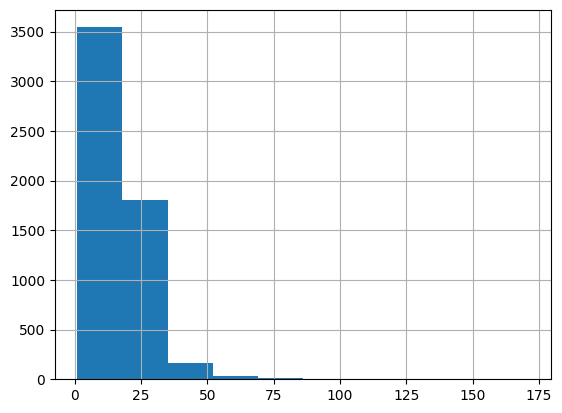

In [137]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_count'].hist()

In [140]:
df['word_count'].max()

171

<Axes: >

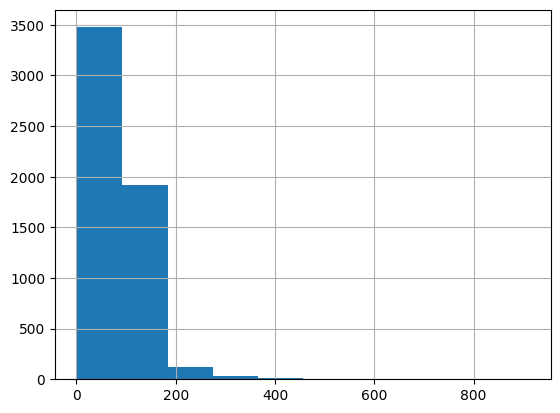

In [138]:
df['char_count'] = df['text'].apply(lambda x: len(x))
df['char_count'].hist()

In [141]:
df['char_count'].max()

910

In [139]:
df.isnull().sum()

,0
text,0
label,0
word_count,0
char_count,0


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [142]:
#there is no missing values

In [144]:
#Filter by text length:
min_length = 10
max_length = 600
df = df[df['text'].str.split().str.len().between(min_length, max_length)]
df.shape

(3555, 4)

In [145]:
stop_words = set(stopwords.words('english'))

In [146]:
#Text cleaning:
def clean_text(text):

  #Removing links (URLs):
  cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

  #Removing special characters and punctuation:
  cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

   # make all char to lower case
  cleaned_text = text.lower()

  #first tokenize
  words = nltk.word_tokenize(cleaned_text)

  #now remove
  filtered_words = [word for word in words if word not in stop_words]

  #Stemming:
  stemmer = ISRIStemmer()
  stemmed_words = [stemmer.stem(word) for word in filtered_words]

  #join again
  cleaned_text = ' '.join(stemmed_words)
  return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)


<ipython-input-146-7f9331fad5de>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


In [147]:
df.head(5)

,text,label,word_count,char_count,clean_text
0,"Go until jurong point, crazy.. Available only ...",ham,20,111,"go jurong point , crazy .. available bugis n g..."
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,29,173,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,ham,12,67,u dun say early hor ... u c already say ... ht...
4,"Nah I don't think he goes to usf, he lives aro...",ham,14,79,"nah n't think goes usf , lives around though h..."
5,FreeMsg Hey there darling it's been 3 week's n...,spam,33,166,freemsg hey darling 's 3 week 's word back ! '...


In [149]:
df = df.drop('text', axis=1)

In [150]:
df['text']= df['clean_text']

In [151]:
print(df['text'])

0       go jurong point , crazy .. available bugis n g...
2       free entry 2 wkly comp win fa cup final tkts 2...
3       u dun say early hor ... u c already say ... ht...
4       nah n't think goes usf , lives around though h...
5       freemsg hey darling 's 3 week 's word back ! '...
                              ...                        
5564              n't wait 'til least wednesday see get .
5566    reminder o2 : get 2.50 pounds free call credit...
5567    2nd time tried 2 contact u. u å£750 pound priz...
5569    pity , * mood . ... suggestions ? https : //li...
5570    guy bitching acted like 'd interested buying s...
Name: text, Length: 3555, dtype: object


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [152]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [153]:
sequences = tokenizer.texts_to_sequences(df['text'])

In [155]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [157]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

In [160]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [161]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((711, 600), (711,), (2844, 600), (2844,))

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [172]:
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=max_length))
model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 600, 512)            │       4,057,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 600, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,271,105 (16.29 MB)

 Trainable params: 4,271,105 (16.29 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [174]:
batch_size = 64

In [175]:
train_dataset = tensorflow.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tensorflow.data.Dataset.from_tensor_slices((X_test, y_test))

In [176]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [177]:
history = model.fit(train_dataset, epochs=4, validation_data=test_dataset)

Epoch 1/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.7906 - loss: 0.4391 - val_accuracy: 0.9705 - val_loss: 0.0966
Epoch 2/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.9865 - loss: 0.0531 - val_accuracy: 0.9719 - val_loss: 0.1199
Epoch 3/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9959 - loss: 0.0169 - val_accuracy: 0.9747 - val_loss: 0.1182
Epoch 4/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9761 - val_loss: 0.1247


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [179]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9780 - loss: 0.1321
Test Loss: 0.12469962239265442, Test Accuracy: 0.9760900139808655


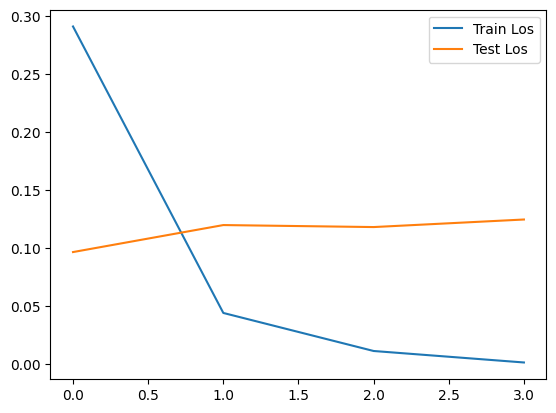

In [184]:
plt.plot(history.history['loss'], label='Train Los')
plt.plot(history.history['val_loss'], label='Test Los')
plt.legend(loc='upper right')
plt.show()


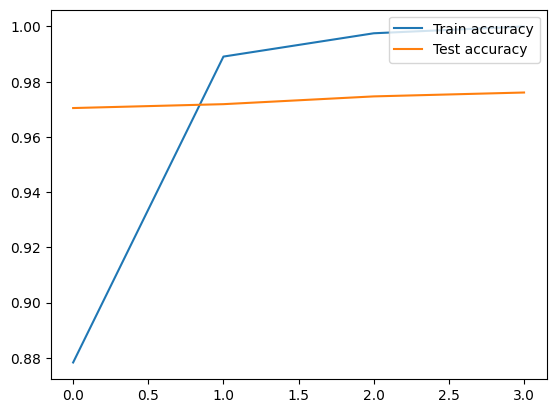

In [183]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend(loc='upper right')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [232]:
# sample

sample_text = ["I have meeting"]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded_sequences = pad_sequences(sample_sequences, maxlen=max_length, padding='post')


predictions = model.predict(sample_padded_sequences)
pred = label_encoder.inverse_transform([predictions.argmax()])
print(f"Predicted Label: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label: ['ham']


In [198]:
# sample 2

sample_text = ["free shipping"]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded_sequences = pad_sequences(sample_sequences, maxlen=max_length, padding='post')


predictions = model.predict(sample_padded_sequences)
pred = label_encoder.inverse_transform([predictions.argmax()])
print(f"Predicted Label: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Label: ['ham']


# sloution in another way, the data is not balanced in labels

loading data, exploring and preprocessing is done before.

In [199]:
!pip install imbalanced-learn==1.1.0

ERROR: Could not find a version that satisfies the requirement imbalanced-learn==1.1.0 (from versions: 0.1.1, 0.1.2, 0.1.3, 0.1.5, 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.6.2, 0.7.0, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.12.2, 0.12.3)
ERROR: No matching distribution found for imbalanced-learn==1.1.0


In [208]:
# balanced the labels

import pandas as pd
from sklearn.utils import resample
df = pd.DataFrame(df)
df_ham = df[df['label'] == 'ham']
df_spam = df[df['label'] == 'spam']
df_ham_downsampled = resample(df_ham,
                              replace=False,
                              n_samples=len(df_spam),
                              random_state=42)
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.head()
print(df_balanced['label'].value_counts())


label
spam    724
ham     724
Name: count, dtype: int64


In [210]:
df_balanced['label'].value_counts()

,count
label,
spam,724
ham,724


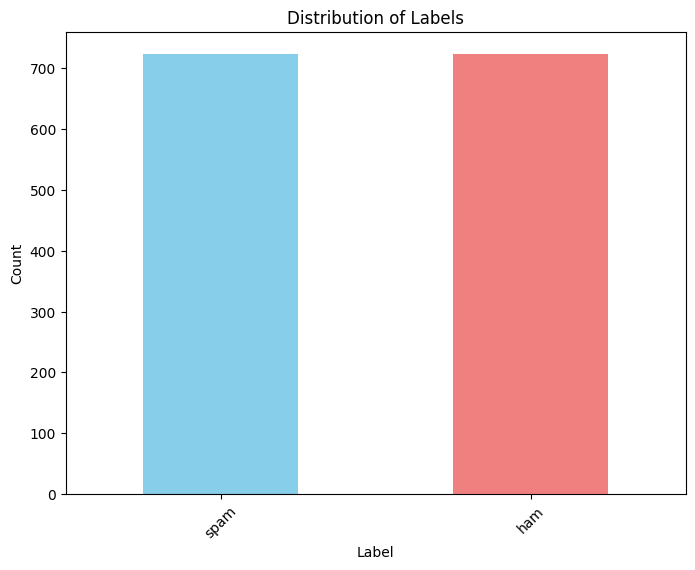

In [212]:
df_filtered = df_balanced[df_balanced['label'].isin(['ham', 'spam'])]
plt.figure(figsize=(8, 6))
df_filtered['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [214]:
df= df_balanced
df

,label,word_count,char_count,clean_text,text
0,spam,26,156,guaranteed å£1000 cash å£2000 prize . claim yr...,guaranteed å£1000 cash å£2000 prize . claim yr...
1,ham,24,128,"come , slave . ... going shell unconsciously a...","come , slave . ... going shell unconsciously a..."
2,spam,20,156,"smsservices . yourinclusive text credits , pls...","smsservices . yourinclusive text credits , pls..."
3,ham,21,134,'s going ? got exciting karaoke type activitie...,'s going ? got exciting karaoke type activitie...
4,ham,18,100,"jolly good ! way , give u tickets sat eve 7.30...","jolly good ! way , give u tickets sat eve 7.30..."
...,...,...,...,...,...
1443,spam,28,176,december ! mobile 11mths+ ? entitled update la...,december ! mobile 11mths+ ? entitled update la...
1444,spam,19,112,good luck ! draw takes place 28th feb 06. good...,good luck ! draw takes place 28th feb 06. good...
1445,spam,26,161,congrats ! 2 mobile 3g videophones r . call 09...,congrats ! 2 mobile 3g videophones r . call 09...
1446,spam,24,143,u secret admirer looking 2 make contact u-find...,u secret admirer looking 2 make contact u-find...


In [216]:
# Tokenization, Padding, and Data Splitting
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((290, 600), (290,), (1158, 600), (1158,))

In [219]:
# Building the Classifier
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=max_length))
model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 600, 512)            │       2,550,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 600, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,289 (10.54 MB)

 Trainable params: 2,764,289 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

In [220]:
# Defining Batch Size, Creating Datasets, and Training the Model

batch_size = 64
train_dataset = tensorflow.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tensorflow.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
history = model.fit(train_dataset, epochs=4, validation_data=test_dataset)

Epoch 1/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.6434 - loss: 0.6316 - val_accuracy: 0.7207 - val_loss: 0.5921
Epoch 2/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step - accuracy: 0.8381 - loss: 0.4176 - val_accuracy: 0.9000 - val_loss: 0.3170
Epoch 3/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.9825 - loss: 0.0687 - val_accuracy: 0.8862 - val_loss: 0.3131
Epoch 4/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.9103 - val_loss: 0.3188


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8963 - loss: 0.3654
Test Loss: 0.3187852203845978, Test Accuracy: 0.9103448390960693


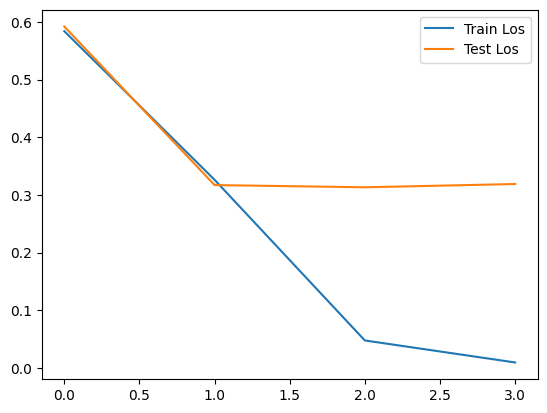

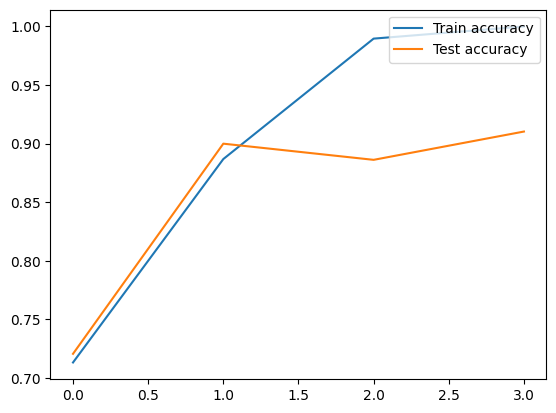

In [221]:
# Model Evaluation
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
plt.plot(history.history['loss'], label='Train Los')
plt.plot(history.history['val_loss'], label='Test Los')
plt.legend(loc='upper right')
plt.show()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend(loc='upper right')
plt.show()

In [222]:
# Model Inference

# sample

sample_text = ["I have meeting"]
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded_sequences = pad_sequences(sample_sequences, maxlen=max_length, padding='post')


predictions = model.predict(sample_padded_sequences)
pred = label_encoder.inverse_transform([predictions.argmax()])
print(f"Predicted Label: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Predicted Label: ['ham']


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

sloution:


 1- Lowercasing, toavoid case sensitivity.


 2- RNN to capture the context of the feuture

 3- to avoid overfitting and underfitting

 4- accuracy to give the real metrics values

5-  No it does not have, the overfitting if the training acc is good but the val or test acc is not good. the under fitting if the train and val have a low acc.

 6- for overfitting Regularization and Augmentation. for underfitting, add more layers or units and increase the epochs.